<a href="https://colab.research.google.com/github/Gouthamyeluri/humanfalldecection/blob/main/FallDitectio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision.models as models


In [ ]:
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from fastprogress import progress_bar
%matplotlib inline
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%%bash
for i in {1,3,4,10}; do \
    cp -r /content/drive/My\ Drive/unzip/Camera2_training_competition/Subject$i ./
done

In [ ]:
!cp /content/drive/My\ Drive/unzip/CompleteDataSet_training_competition.csv ./

In [ ]:
sensor_data=pd.read_csv("/content/CompleteDataSet_training_competition.csv")



In [ ]:
sensor_data.head()

,TimeStamps,AnkleAccelerometer x-axis,AnkleAccelerometer y-axis,AnkleAccelerometer z-axis,AnkleAngularVelocity x-axis,AnkleAngularVelocity y-axis,AnkleAngularVelocity z-axis,AnkleLuminosity illuminance,RightPocketAccelerometer x-axis,RightPocketAccelerometer y-axis,RightPocketAccelerometer z-axis,RightPocketAngularVelocity x-axis,RightPocketAngularVelocity y-axis,RightPocketAngularVelocity z-axis,RightPocketLuminosity illuminance,BeltAccelerometer x-axis,BeltAccelerometer y-axis,BeltAccelerometer z-axis,BeltAngularVelocity x-axis,BeltAngularVelocity y-axis,BeltAngularVelocity z-axis,BeltLuminosity illuminance,NeckAccelerometer x-axis,NeckAccelerometer y-axis,NeckAccelerometer z-axis,NeckAngularVelocity x-axis,NeckAngularVelocity y-axis,NeckAngularVelocity z-axis,NeckLuminosity illuminance,WristAccelerometer x-axis,WristAccelerometer y-axis,WristAccelerometer z-axis,WristAngularVelocity x-axis,WristAngularVelocity y-axis,WristAngularVelocity z-axis,WristLuminosity illuminance,BrainSensor,Infrared1,Infrared2,Infrared3,Infrared4,Infrared5,Infrared6,Subject,Trial,Activity,Tag
0,2018-07-04T12:04:17.738369,-1.005,0.229,-0.083,-0.671,0.488,-2.683,0.0,-0.981,0.260,0.098,1.768,-1.890,0.732,0.0,0.146,0.895,0.367,-1.463,-3.841,-2.622,392.633,-0.672,0.072,-0.815,-3.293,-7.805,9.207,1231.336,-1.240,-0.557,0.227,-75.854,44.024,315.915,2108.154,45,1,1,1,1,1,1,1,1,1,7
1,2018-07-04T12:04:17.790509,-1.005,0.228,-0.082,-3.415,-0.549,0.122,0.0,-0.981,0.260,0.098,3.354,-2.500,-0.061,0.0,0.146,0.895,0.367,1.037,-4.024,-1.768,392.633,-0.672,0.072,-0.815,-9.756,-8.049,5.122,1231.336,-1.240,-0.557,0.227,-28.780,55.549,344.146,2108.154,1,1,1,1,1,1,1,1,1,1,7
2,2018-07-04T12:04:17.836632,-1.005,0.231,-0.079,-2.622,-1.402,-0.549,0.0,-0.975,0.282,0.091,3.720,-2.500,-0.793,0.0,0.178,0.896,0.373,0.366,-2.500,-0.488,392.633,-0.705,0.084,-0.779,-17.866,-18.354,4.329,1231.336,-1.884,-0.687,0.251,27.256,87.134,372.012,2108.154,325,1,1,1,1,1,1,1,1,1,7
3,2018-07-04T12:04:17.885262,-1.005,0.231,-0.079,-2.561,-2.195,-1.220,0.0,-0.973,0.301,0.103,-1.951,-1.159,-1.280,0.0,0.160,0.895,0.372,0.854,1.951,1.585,392.633,-0.727,0.095,-0.758,-18.537,-10.061,0.366,1231.336,-1.884,-0.687,0.251,2.866,117.683,356.463,2108.154,396,1,1,1,1,1,1,1,1,1,7
4,2018-07-04T12:04:17.945423,-1.008,0.229,-0.072,-3.537,-2.073,-0.305,0.0,-0.973,0.301,0.103,-5.366,-1.280,-0.732,0.0,0.160,0.895,0.372,2.012,4.634,3.354,392.633,-0.727,0.095,-0.758,4.878,2.866,-3.232,1231.336,-1.597,-0.646,0.112,10.000,30.671,126.768,2108.154,-436,1,1,1,1,1,1,1,1,1,7


In [ ]:
assert sensor_data.TimeStamps.nunique()==sensor_data.shape[0]
sensor_data.shape

(160736, 47)

In [ ]:
!mkdir data
!mkdir data/train
!mkdir data/test

In [ ]:
def unzip(subject,activity,trail,is_train_subject):
  extract_dir=f"data/train/"+activity
  if not is_train_subject:
    extract_dir=f"data/test/"+activity
  if not os.path.exists(extract_dir):
    os.mkdir(extract_dir)
  with zipfile.ZipFile(f"{subject}/{activity}/{trail}","r") as zip_ref:
      zip_ref.extractall(extract_dir)

In [ ]:
subject_file_paths=['Subject1','Subject3','Subject4','Subject10']
subject_mode={'Subject1':True,'Subject3':True,'Subject4':True,'Subject10':False}

In [ ]:
%%time
for subject in progress_bar(subject_file_paths):
  for activity in progress_bar(os.listdir(subject)):
    for trail in os.listdir(f"{subject}/{activity}"):unzip(subject,activity,trail,subject_mode[subject])

CPU times: user 1min 44s, sys: 1min 2s, total: 2min 47s
Wall time: 4min 9s


In [ ]:
def clean_directories__get_png_files(path):
  image_names=[]
  for activity in progress_bar(os.listdir(path)):
    for file_ in os.listdir(f"{path}/{activity}"):
      fp=f"{path}/{activity}/{file_}"
      if os.path.isdir(fp):
        print(f"deleting {fp}")
        shutil.rmtree(fp)
      else: image_names.append(file_)
  return image_names 

In [ ]:
train_image_names=clean_directories__get_png_files("data/train")

deleting data/train/Activity1/Subject4Activity1Trial1Camera2Synced


In [ ]:
test_image_names=clean_directories__get_png_files("data/test")

In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
sensor_data_sliced=sensor_data[sensor_data.Subject.isin([1,3,4,10])]

In [ ]:
to_keep_columns=['TimeStamps', 'AnkleAccelerometer x-axis', 'AnkleAccelerometer y-axis',
       'AnkleAccelerometer z-axis', 'AnkleAngularVelocity x-axis ',
       'AnkleAngularVelocity y-axis ', 'AnkleAngularVelocity z-axis ',
        'RightPocketAccelerometer x-axis ',
       'RightPocketAccelerometer y-axis ', 'RightPocketAccelerometer z-axis ',
       'RightPocketAngularVelocity x-axis',
       'RightPocketAngularVelocity y-axis',
       'RightPocketAngularVelocity z-axis',
       'BeltAccelerometer x-axis',
       'BeltAccelerometer y-axis', 'BeltAccelerometer z-axis',
       'BeltAngularVelocity x-axis', 'BeltAngularVelocity y-axis',
       'BeltAngularVelocity z-axis',
       'NeckAccelerometer x-axis', 'NeckAccelerometer y-axis',
       'NeckAccelerometer z-axis', 'NeckAngularVelocity x-axis',
       'NeckAngularVelocity y-axis', 'NeckAngularVelocity z-axis',
      'WristAccelerometer x-axis',
       'WristAccelerometer y-axis', 'WristAccelerometer z-axis',
       'WristAngularVelocity x-axis', 'WristAngularVelocity y-axis',
       'WristAngularVelocity z-axis',"Tag","Activity",'Subject']

In [ ]:
features=to_keep_columns[1:-3]

In [ ]:
features

['AnkleAccelerometer x-axis',
 'AnkleAccelerometer y-axis',
 'AnkleAccelerometer z-axis',
 'AnkleAngularVelocity x-axis ',
 'AnkleAngularVelocity y-axis ',
 'AnkleAngularVelocity z-axis ',
 'RightPocketAccelerometer x-axis ',
 'RightPocketAccelerometer y-axis ',
 'RightPocketAccelerometer z-axis ',
 'RightPocketAngularVelocity x-axis',
 'RightPocketAngularVelocity y-axis',
 'RightPocketAngularVelocity z-axis',
 'BeltAccelerometer x-axis',
 'BeltAccelerometer y-axis',
 'BeltAccelerometer z-axis',
 'BeltAngularVelocity x-axis',
 'BeltAngularVelocity y-axis',
 'BeltAngularVelocity z-axis',
 'NeckAccelerometer x-axis',
 'NeckAccelerometer y-axis',
 'NeckAccelerometer z-axis',
 'NeckAngularVelocity x-axis',
 'NeckAngularVelocity y-axis',
 'NeckAngularVelocity z-axis',
 'WristAccelerometer x-axis',
 'WristAccelerometer y-axis',
 'WristAccelerometer z-axis',
 'WristAngularVelocity x-axis',
 'WristAngularVelocity y-axis',
 'WristAngularVelocity z-axis']

In [ ]:
sliced_csv=sensor_data_sliced[to_keep_columns]

In [ ]:
train_csv=sliced_csv[sliced_csv.Subject.isin([1,3,4])]
test_csv=sliced_csv[sliced_csv.Subject==10]

In [ ]:
def map_and_drop_missing_data(image_files,csv):
  print("Images from cam",len(image_files))
  print("sensor data",csv.shape)
  image_ids=[val[:-4] for val in image_files]

  csv_ids=csv.TimeStamps.values
  image_compatible_csv_ids=[val.replace(':','_') for val in csv_ids]

  to_conider_image_files=set(image_ids).intersection(image_compatible_csv_ids)
  remapped_csv_ids=[val.replace('_',':') for val in image_compatible_csv_ids]
  print("final images",len(remapped_csv_ids))
  return csv[csv.TimeStamps.isin(remapped_csv_ids)]

In [ ]:
final_train_csv=map_and_drop_missing_data(train_image_names,train_csv)

Images from cam 53594
sensor data (53592, 34)
final images 53592


In [ ]:
final_train_csv.head(5)

,TimeStamps,AnkleAccelerometer x-axis,AnkleAccelerometer y-axis,AnkleAccelerometer z-axis,AnkleAngularVelocity x-axis,AnkleAngularVelocity y-axis,AnkleAngularVelocity z-axis,RightPocketAccelerometer x-axis,RightPocketAccelerometer y-axis,RightPocketAccelerometer z-axis,RightPocketAngularVelocity x-axis,RightPocketAngularVelocity y-axis,RightPocketAngularVelocity z-axis,BeltAccelerometer x-axis,BeltAccelerometer y-axis,BeltAccelerometer z-axis,BeltAngularVelocity x-axis,BeltAngularVelocity y-axis,BeltAngularVelocity z-axis,NeckAccelerometer x-axis,NeckAccelerometer y-axis,NeckAccelerometer z-axis,NeckAngularVelocity x-axis,NeckAngularVelocity y-axis,NeckAngularVelocity z-axis,WristAccelerometer x-axis,WristAccelerometer y-axis,WristAccelerometer z-axis,WristAngularVelocity x-axis,WristAngularVelocity y-axis,WristAngularVelocity z-axis,Tag,Activity,Subject
0,2018-07-04T12:04:17.738369,-1.005,0.229,-0.083,-0.671,0.488,-2.683,-0.981,0.260,0.098,1.768,-1.890,0.732,0.146,0.895,0.367,-1.463,-3.841,-2.622,-0.672,0.072,-0.815,-3.293,-7.805,9.207,-1.240,-0.557,0.227,-75.854,44.024,315.915,7,1,1
1,2018-07-04T12:04:17.790509,-1.005,0.228,-0.082,-3.415,-0.549,0.122,-0.981,0.260,0.098,3.354,-2.500,-0.061,0.146,0.895,0.367,1.037,-4.024,-1.768,-0.672,0.072,-0.815,-9.756,-8.049,5.122,-1.240,-0.557,0.227,-28.780,55.549,344.146,7,1,1
2,2018-07-04T12:04:17.836632,-1.005,0.231,-0.079,-2.622,-1.402,-0.549,-0.975,0.282,0.091,3.720,-2.500,-0.793,0.178,0.896,0.373,0.366,-2.500,-0.488,-0.705,0.084,-0.779,-17.866,-18.354,4.329,-1.884,-0.687,0.251,27.256,87.134,372.012,7,1,1
3,2018-07-04T12:04:17.885262,-1.005,0.231,-0.079,-2.561,-2.195,-1.220,-0.973,0.301,0.103,-1.951,-1.159,-1.280,0.160,0.895,0.372,0.854,1.951,1.585,-0.727,0.095,-0.758,-18.537,-10.061,0.366,-1.884,-0.687,0.251,2.866,117.683,356.463,7,1,1
4,2018-07-04T12:04:17.945423,-1.008,0.229,-0.072,-3.537,-2.073,-0.305,-0.973,0.301,0.103,-5.366,-1.280,-0.732,0.160,0.895,0.372,2.012,4.634,3.354,-0.727,0.095,-0.758,4.878,2.866,-3.232,-1.597,-0.646,0.112,10.000,30.671,126.768,7,1,1


In [ ]:
final_test_csv=map_and_drop_missing_data(test_image_names,test_csv)

Images from cam 17601
sensor data (17601, 34)
final images 17601


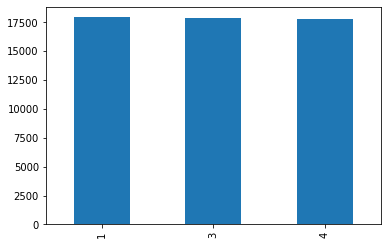

In [ ]:
final_train_csv.Subject.value_counts().plot(kind='bar')

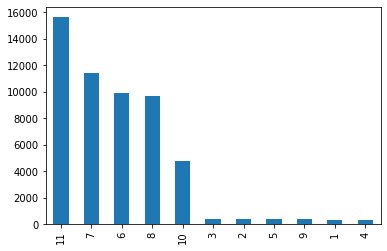

In [ ]:
final_train_csv.Tag.value_counts().plot(kind='bar')

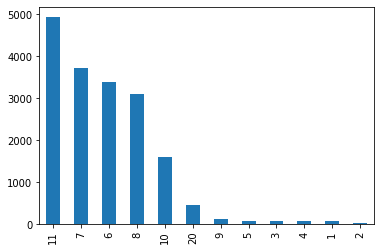

In [ ]:
final_test_csv.Tag.value_counts().plot(kind='bar')

In [ ]:
def map_image__csv(ts,activity):
  ts=ts.replace(':','_')
  image_path=f"Activity{activity}/{ts}.png"
  return image_path
def rearrange_dataframe(df):
  df["id"]=df.apply(lambda x:map_image__csv(x['TimeStamps'], x['Activity']),axis=1)
  return df

In [ ]:
final_train_csv=rearrange_dataframe(final_train_csv)
final_test_csv=rearrange_dataframe(final_test_csv)

In [ ]:
final_test_csv["Tag"]=final_test_csv["Tag"]-1
final_train_csv["Tag"]=final_train_csv["Tag"]-1

In [ ]:
final_train_csv[final_train_csv.Tag==1].head(5)


,TimeStamps,AnkleAccelerometer x-axis,AnkleAccelerometer y-axis,AnkleAccelerometer z-axis,AnkleAngularVelocity x-axis,AnkleAngularVelocity y-axis,AnkleAngularVelocity z-axis,RightPocketAccelerometer x-axis,RightPocketAccelerometer y-axis,RightPocketAccelerometer z-axis,RightPocketAngularVelocity x-axis,RightPocketAngularVelocity y-axis,RightPocketAngularVelocity z-axis,BeltAccelerometer x-axis,BeltAccelerometer y-axis,BeltAccelerometer z-axis,BeltAngularVelocity x-axis,BeltAngularVelocity y-axis,BeltAngularVelocity z-axis,NeckAccelerometer x-axis,NeckAccelerometer y-axis,NeckAccelerometer z-axis,NeckAngularVelocity x-axis,NeckAngularVelocity y-axis,NeckAngularVelocity z-axis,WristAccelerometer x-axis,WristAccelerometer y-axis,WristAccelerometer z-axis,WristAngularVelocity x-axis,WristAngularVelocity y-axis,WristAngularVelocity z-axis,Tag,Activity,Subject,id
590,2018-07-04T12:05:19.991793,-1.031,0.129,-0.065,-2.866,-1.098,0.732,-0.932,0.400,0.086,4.146,3.598,-9.146,0.074,0.898,0.365,14.268,-7.378,1.463,-0.732,0.026,-0.827,3.720,27.744,17.805,-0.953,-0.304,0.087,-12.195,-2.805,-4.573,1,2,1,Activity2/2018-07-04T12_05_19.991793.png
591,2018-07-04T12:05:20.041927,-1.031,0.129,-0.065,-4.634,-0.061,-2.317,-0.950,0.394,0.037,-24.451,38.659,-10.000,0.097,0.925,0.356,4.817,-3.476,-1.098,-0.694,0.078,-0.813,7.195,-0.549,14.390,-0.953,-0.304,0.087,-28.232,-0.183,-6.646,1,2,1,Activity2/2018-07-04T12_05_20.041927.png
592,2018-07-04T12:05:20.087549,-1.024,0.112,-0.070,-4.939,-1.524,-2.927,-0.950,0.394,0.037,-72.683,73.537,-8.720,0.076,0.898,0.367,8.780,-5.610,1.524,-0.694,0.078,-0.813,8.232,4.756,17.805,-0.876,-0.331,0.112,-30.915,24.268,-9.390,1,2,1,Activity2/2018-07-04T12_05_20.087549.png
593,2018-07-04T12:05:20.133672,-1.024,0.103,-0.063,-4.390,1.707,-13.049,-0.945,0.354,0.045,10.305,-28.841,-2.744,0.076,0.898,0.367,6.646,-3.902,0.244,-0.672,0.068,-0.774,11.524,-10.793,12.927,-0.923,-0.358,0.189,8.598,31.707,-7.134,1,2,1,Activity2/2018-07-04T12_05_20.133672.png
594,2018-07-04T12:05:20.187316,-1.024,0.103,-0.063,-4.573,3.110,-16.159,-0.908,0.407,0.071,17.317,-14.817,-1.402,0.075,0.891,0.377,4.024,-3.780,-1.280,-0.672,0.068,-0.774,7.927,-7.805,12.500,-0.923,-0.358,0.189,39.512,32.622,-5.366,1,2,1,Activity2/2018-07-04T12_05_20.187316.png


In [ ]:
final_train_csv.max()

TimeStamps                                         2018-07-10T13:50:27.073466
AnkleAccelerometer x-axis                                               2.367
AnkleAccelerometer y-axis                                               4.081
AnkleAccelerometer z-axis                                                 2.4
AnkleAngularVelocity x-axis                                           741.098
AnkleAngularVelocity y-axis                                           634.329
AnkleAngularVelocity z-axis                                           431.463
RightPocketAccelerometer x-axis                                         3.218
RightPocketAccelerometer y-axis                                         4.401
RightPocketAccelerometer z-axis                                         4.638
RightPocketAngularVelocity x-axis                                     427.866
RightPocketAngularVelocity y-axis                                     514.207
RightPocketAngularVelocity z-axis                               

In [ ]:
from fastai.vision import *
import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
restnet=models.resnet34(pretrained=True, progress=True)
restnet_updated = nn.Sequential(*list(restnet.children())[:-1])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 55.6MB/s]


In [ ]:
device="cuda:0"

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir,features=features):
        self.csv_file, self.root_dir,self.features= csv_file, root_dir,features
        self.c = 11 # binary label
        self.classes=[f'Tag{i+1}' for i in range(10)]
  
    
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, i):
        img_name = os.path.join(self.root_dir,
                            self.csv_file["id"].iloc[i])
        
        image = cv2.imread(img_name)
        image=cv2.resize(image,(224,224))
        image=image.reshape(3,224,224)
        image=image/255
        sensors_data_array = np.array(self.csv_file[self.features].iloc[i]).astype(np.float32)
  
        return [image,sensors_data_array], self.csv_file["Tag"].iloc[i]

In [ ]:
final_test_csv=final_test_csv[final_test_csv.Tag<=10]

In [ ]:
train_ds, valid_ds = CustomDataset(final_train_csv,"/content/data/train"), CustomDataset(final_test_csv,"/content/data/test")

In [ ]:
data = DataBunch.create(train_ds, valid_ds, bs=32, num_workers=1)
l=data.one_batch()

In [ ]:
class LsfmNet(nn.Module):
    def __init__(self,init_net,no_sensor_features,classes):
        super(LsfmNet, self).__init__()
        self.restnet = init_net
        self.fc1 = nn.Linear(512, 120)
        self.fc2 = nn.Linear(120+no_sensor_features, 60)
        self.fc3 = nn.Linear(60, classes)

    def forward(self, image,data):
        image=image.type(torch.float32)
        rest_out = self.restnet(image)
        x1=self.fc1(rest_out.squeeze())
        if len(x1.size())==1:x1=torch.unsqueeze(x1, dim=0)
        x = torch.cat((x1, data), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x)


lsfmnet = LsfmNet(restnet_updated,30,11)

In [ ]:
len(features)

30

In [ ]:
learn = Learner(data, lsfmnet, metrics=error_rate,loss_func = nn.CrossEntropyLoss())

In [ ]:
learn.lr_find()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


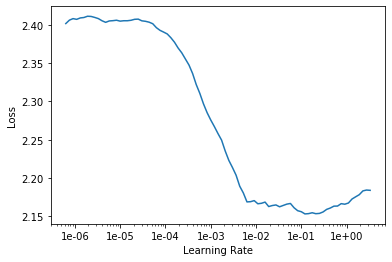

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8,max_lr=3*1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.617627,1.717595,0.167658,24:37
1,1.608393,1.677428,0.133473,24:48
2,1.607836,1.706643,0.162700,24:45
3,1.598606,1.647536,0.101447,24:58
4,1.596403,1.717782,0.174542,24:51
5,1.594844,1.644712,0.101972,24:40
6,1.591051,1.671642,0.128806,25:26


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Buffered data was truncated after reaching the output size limit.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [ ]:
len(idxs),len(losses)

(17142, 17142)

In [ ]:
class Dummy:
  def __init__(self):
    self.classes=[f'Activity{i+1}' for i in range(11)]
y=Dummy()
CustomDataset.y=y

In [ ]:
CustomDataset.c=11

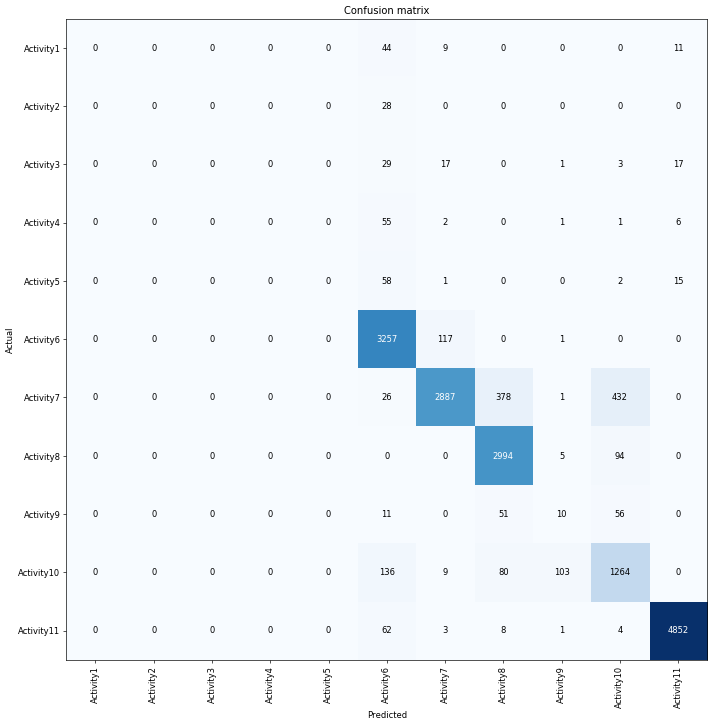

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
((10412+4852)/(12212+4852+78))*100

89.04445222261113

In [ ]:
learn.unfreeze()
learn.lr_find()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
